In [32]:
import torch
import seaborn as sns
from pyro.distributions import transforms as T
import pyro.distributions as dist
from torch import nn
import matplotlib.pyplot as plt

In [33]:
dataset = torch.cat([torch.randn(64), torch.randn(8) + 6])[:, None]

<AxesSubplot:ylabel='Density'>

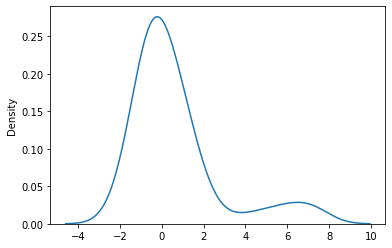

In [34]:
sns.kdeplot(dataset.squeeze())

In [35]:
d = 1
n_layers = 8

In [36]:
transforms = nn.ModuleList([T.planar(d) for _ in range(n_layers)])
base_dist = dist.Normal(0, 1)

def log_prob(x, transforms, base_dist):
    x= x.clone()
    J = 0
    for t in transforms:
        y = t(x)
        J += t.log_abs_det_jacobian(x, y)
        x = y
    log_prob = base_dist.log_prob(x).squeeze() + J
    return log_prob, y

steps = 32768
optimizer = torch.optim.Adam(transforms.parameters(), lr=1e-2)
for step in range(steps+1):
    optimizer.zero_grad()
    lp, y = log_prob(dataset, transforms, base_dist)
    loss = -lp.mean()
#     loss = -log_prob(flow_dist, dataset).mean()
    loss.backward()
    optimizer.step()
    
    
    
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))


step: 0, loss: 3.499338150024414
step: 500, loss: 1.6699098348617554


KeyboardInterrupt: 

In [7]:
x = torch.linspace(-5, 5, 128)[:, None]

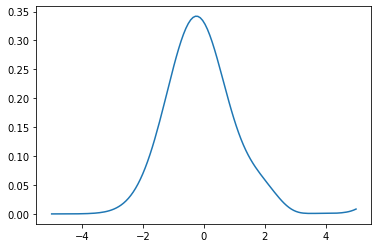

In [9]:
with torch.no_grad():
    lp, y = log_prob(x, transforms, base_dist)

    plt.plot(x.squeeze(), lp.exp().squeeze())


<AxesSubplot:ylabel='Density'>

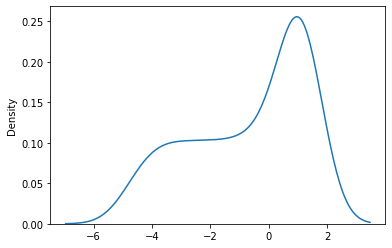

In [12]:
sns.kdeplot(y.squeeze())

<AxesSubplot:ylabel='Density'>

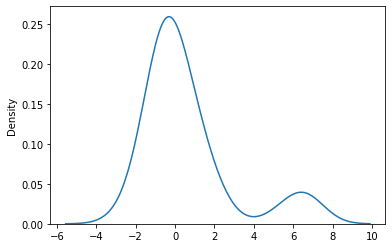

In [11]:
sns.kdeplot(dataset.squeeze())

In [55]:
def log_prob(x, transforms, base_dist):
    x = x.clone()
    J = 0
    for t in transforms:
        y = t(x)
        J = J + t.log_abs_det_jacobian(x, y)
        x = y 
        
    log_prob = base_dist.log_prob(x)
    return log_prob, y
        
    

In [22]:
x = torch.randn(32, 32)

step: 0, loss: 3.66283917427063


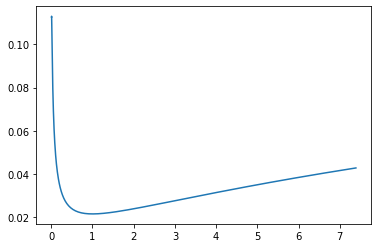

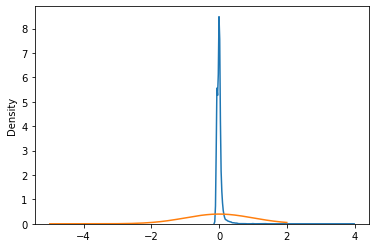

step: 500, loss: 2.2209279537200928


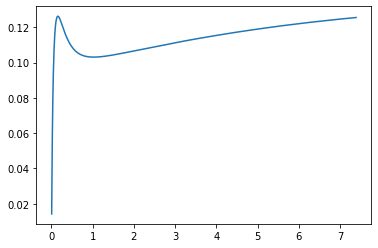

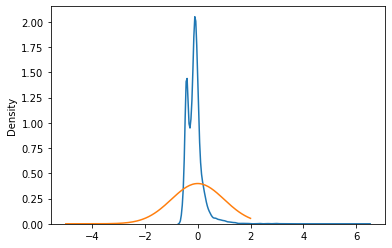

step: 1000, loss: 1.3366737365722656


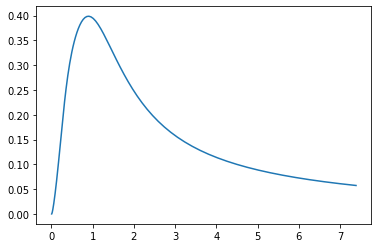

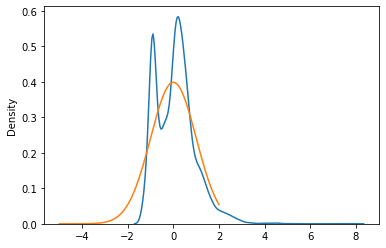

step: 1500, loss: 1.27415931224823


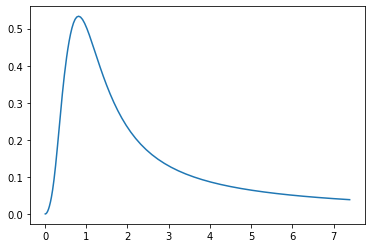

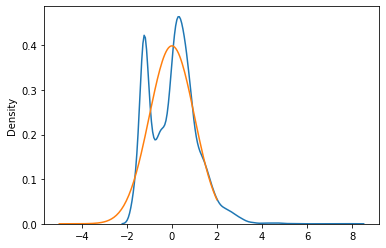

step: 2000, loss: 1.2541892528533936


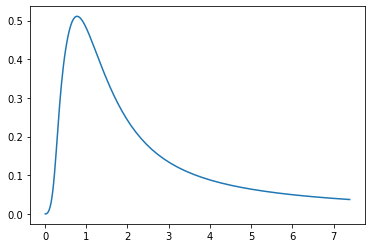

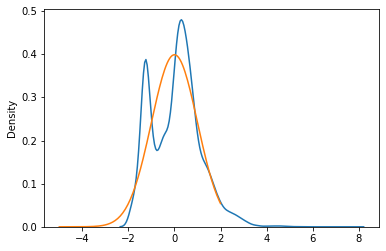

step: 2500, loss: 1.2253087759017944


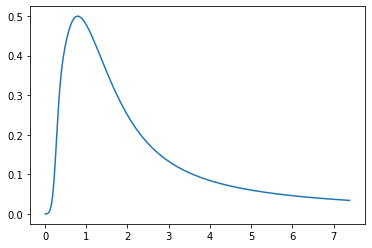

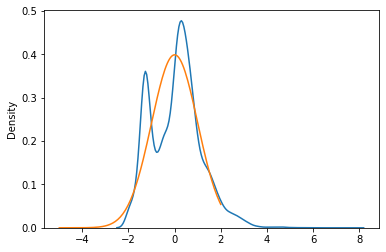

step: 3000, loss: 1.2228741645812988


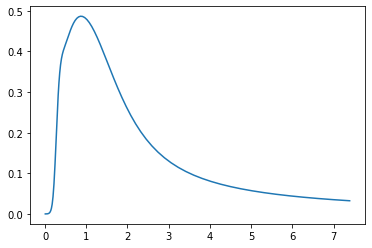

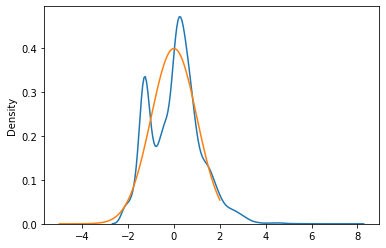

step: 3500, loss: 1.1880067586898804


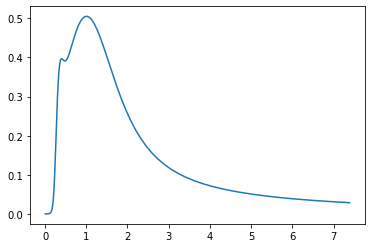

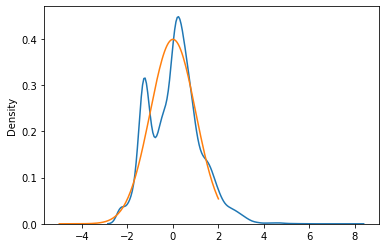

step: 4000, loss: 1.1721830368041992


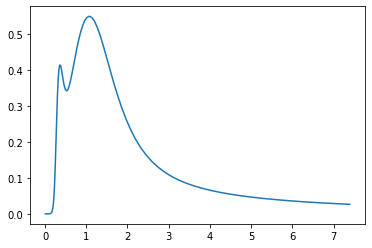

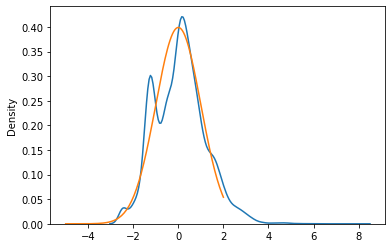

step: 4500, loss: 1.1547573804855347


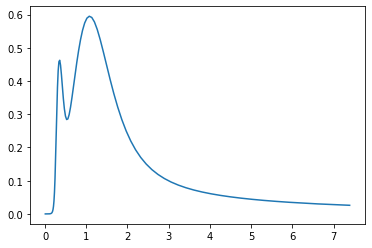

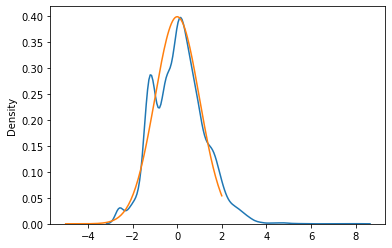

step: 5000, loss: 1.1272032260894775


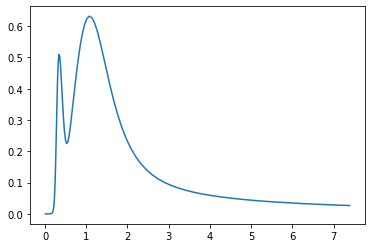

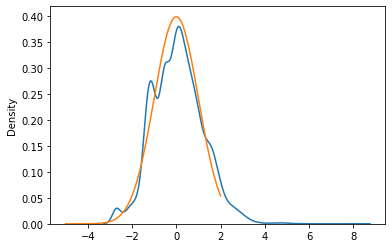

step: 5500, loss: 1.1254661083221436


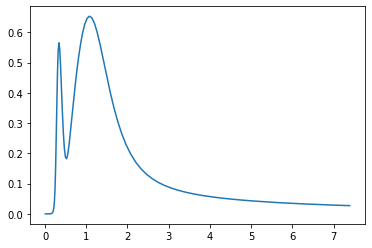

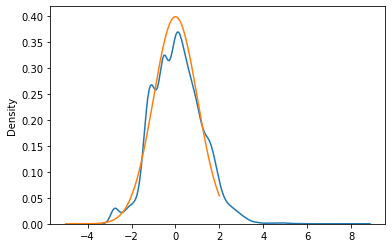

step: 6000, loss: 1.117081880569458


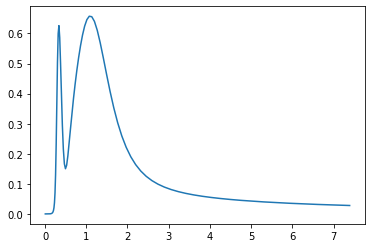

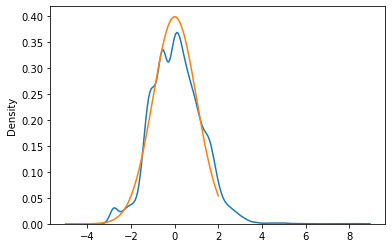

step: 6500, loss: 1.1046432256698608


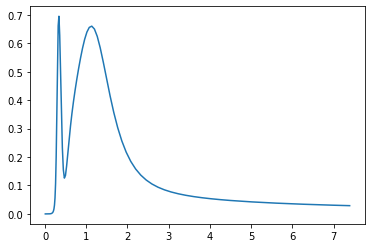

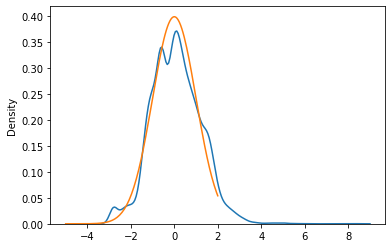

step: 7000, loss: 1.0794498920440674


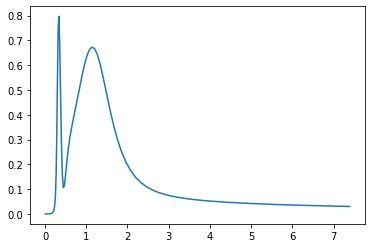

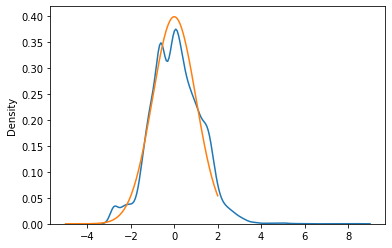

step: 7500, loss: 1.072724461555481


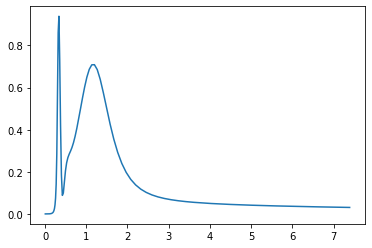

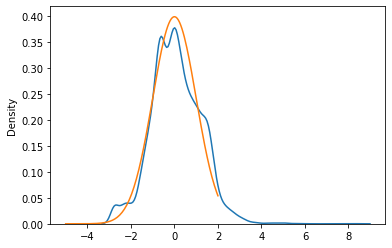

step: 8000, loss: 1.070337176322937


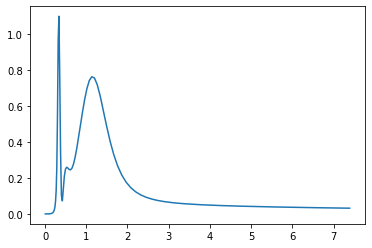

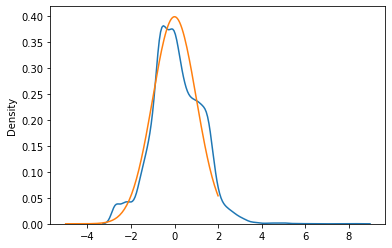

step: 8500, loss: 1.0431510210037231


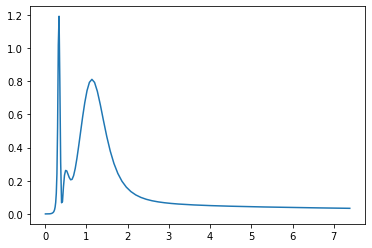

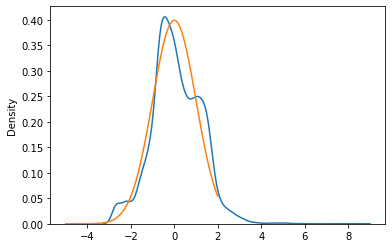

step: 9000, loss: 1.0433170795440674


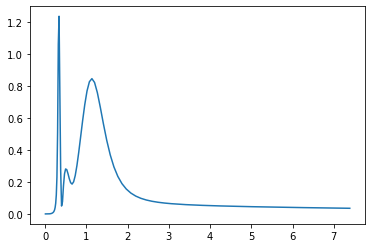

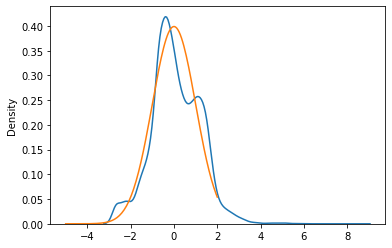

step: 9500, loss: 1.0244683027267456


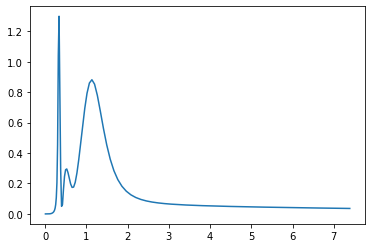

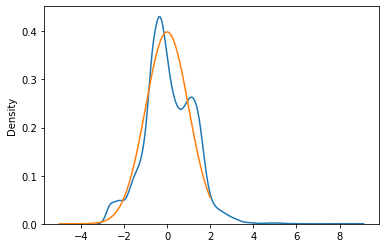

step: 10000, loss: 1.0409950017929077


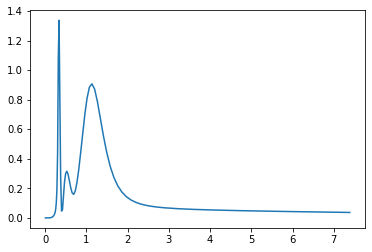

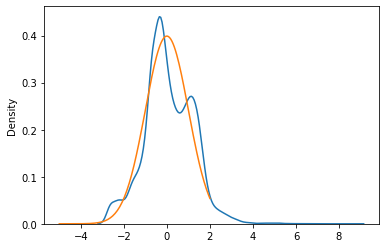

step: 10500, loss: 1.034572958946228


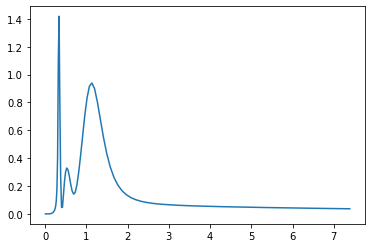

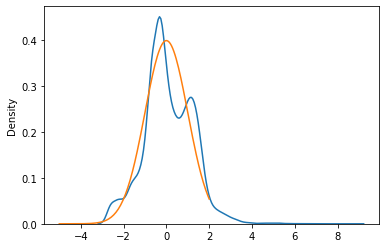

step: 11000, loss: 1.0228745937347412


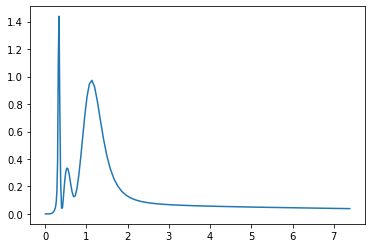

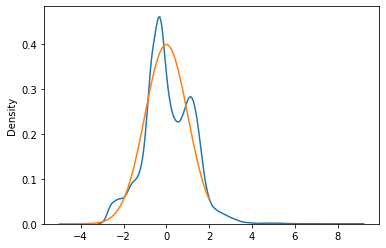

step: 11500, loss: 1.0593328475952148


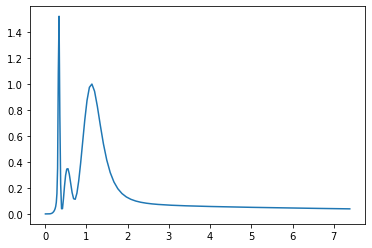

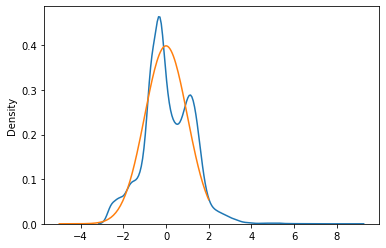

step: 12000, loss: 1.009891152381897


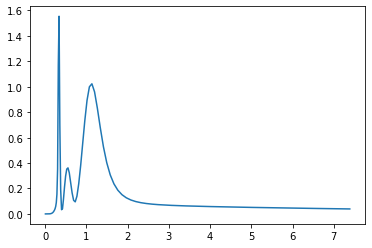

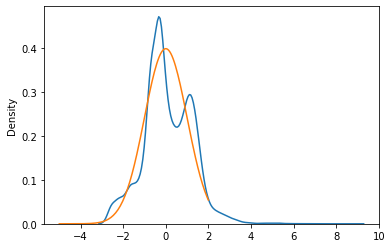

step: 12500, loss: 0.989769458770752


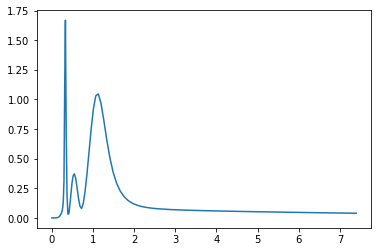

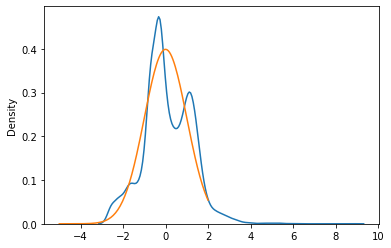

step: 13000, loss: 1.030277132987976


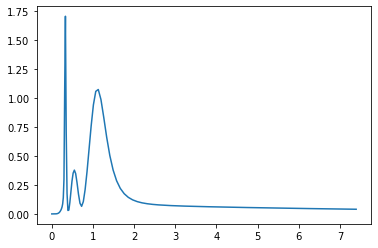

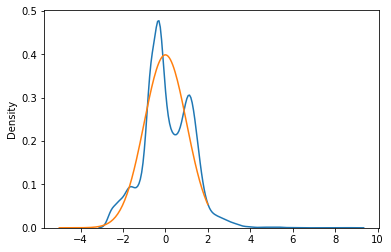

step: 13500, loss: 1.0200092792510986


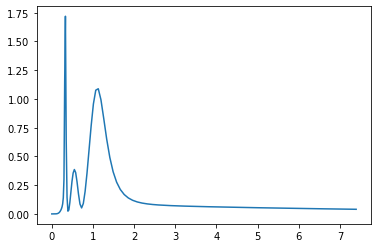

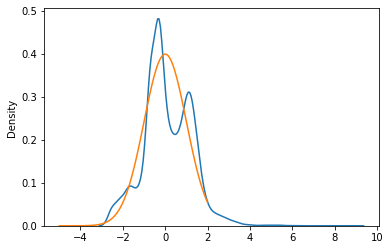

step: 14000, loss: 1.0217097997665405


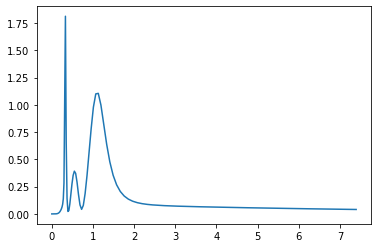

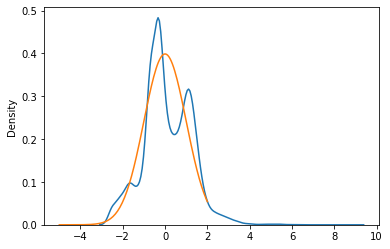

step: 14500, loss: 1.009135365486145


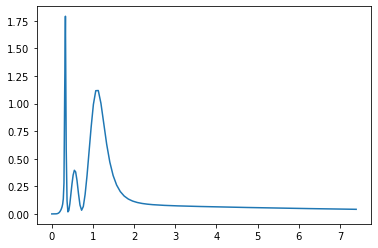

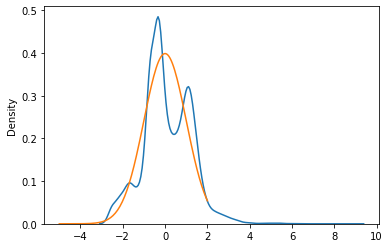

step: 15000, loss: 1.0130616426467896


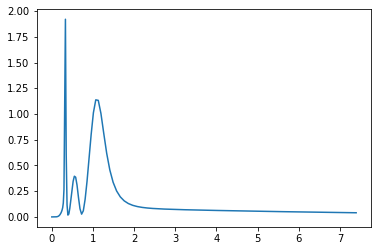

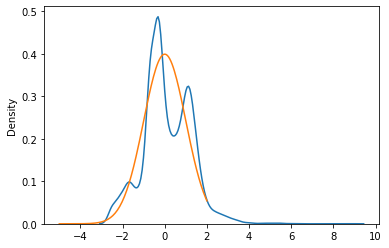

step: 15500, loss: 0.9932157397270203


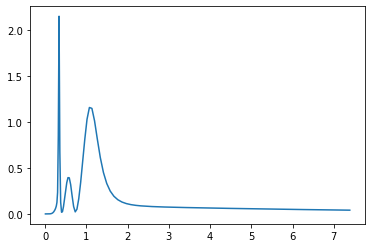

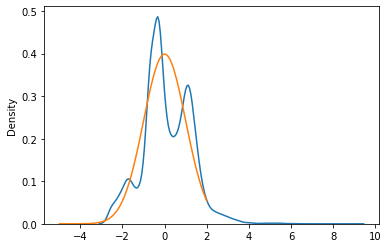

step: 16000, loss: 1.0213284492492676


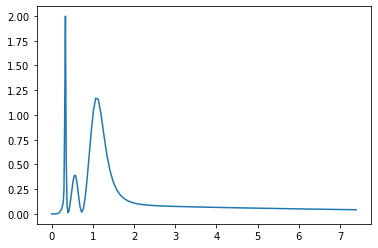

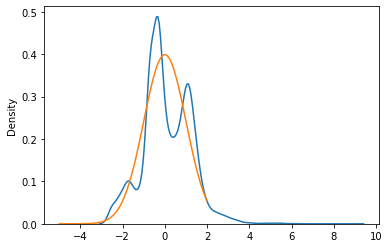

step: 16500, loss: 0.9950158596038818


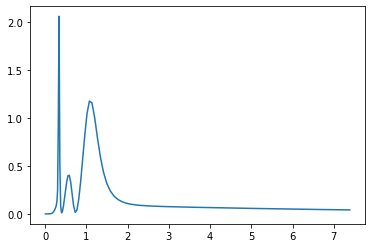

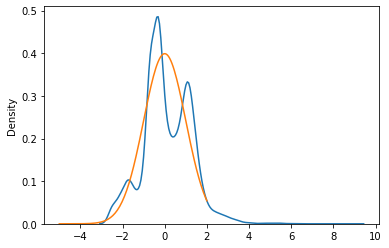

step: 17000, loss: 1.0163344144821167


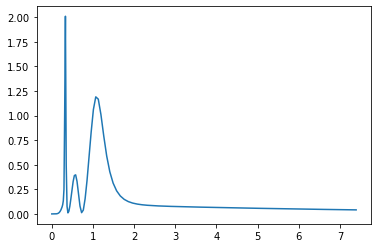

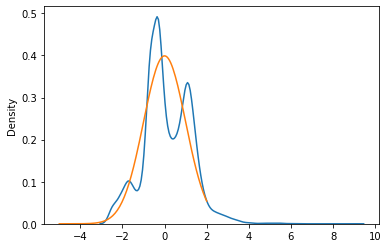

step: 17500, loss: 1.0291404724121094


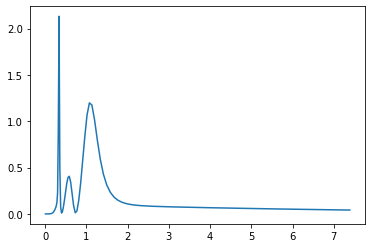

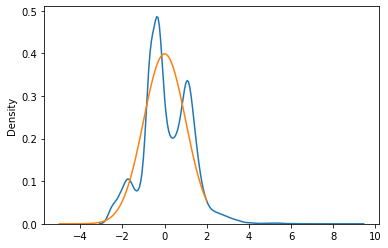

KeyboardInterrupt: 

In [54]:
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro.distributions.transforms as T
import numpy as np
import torch.nn.functional as F

d=1
dataset = np.load('../datasets/Combined_GWTC_m1m2chieffz.npz')

dataset = torch.from_numpy(dataset['m1']).float()[:, :128]

loc = dataset.mean()
scale = dataset.std()

dataset = (dataset - loc) / scale
n_layers = 8
transforms = nn.ModuleList([T.planar(d) for _ in range(n_layers)])
base_dist = dist.Normal(0, 1)



import math

def evaluate():
    with torch.no_grad():
#         x = dataset.clone()
#         for t in transforms:
#             x = t(x)

#         sns.kdeplot(x.squeeze())
        x = torch.linspace(-5, 2, 128)[:, None]
#         plt.show()

        p, y = log_prob(x, transforms, base_dist)
        p = p.exp()
        plt.plot(x.squeeze().exp(), p.squeeze())
        plt.show()
        
        lp, y = log_prob(dataset.reshape(-1, 1), transforms, base_dist)
        y = sns.kdeplot(y.squeeze())
        plt.plot(x.squeeze(), base_dist.log_prob(x).exp())


        plt.show()
        
        
def log_prob(x, transforms, base_dist):
    J = 0
    for t in transforms:
        y = t(x)
        J += t.log_abs_det_jacobian(x, y)
        x = y
    log_prob = base_dist.log_prob(x).squeeze() + J
    return log_prob, y


def log_prob_hierarchical(x, transforms, base_dist):
    batch_size = 32
#     ix = (0,)
    ix = torch.randint(0, x.shape[1], (batch_size,))
    x = x[:, ix]
    lp, y = log_prob(x.reshape(-1, 1), transforms, base_dist)
    lp = lp.view(x.shape)
    lp = torch.logsumexp(lp, dim=-1)         
    lp = lp - math.log(x.shape[-1])
    return lp
        
steps = 32768
optimizer = torch.optim.Adam(transforms.parameters(), lr=5e-4)
# optimizer = torch.optim.RMSprop(transforms.parameters(), lr=1e-2, momentum=0.1)
for step in range(steps+1):
    optimizer.zero_grad()
#     loss = -log_prob(dataset.clone(), transforms, base_dist).mean()
    loss = -log_prob_hierarchical(dataset.clone(), transforms, base_dist).mean()

    loss.backward()
    optimizer.step()
    
    
    
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        evaluate()
#         sample = flow_dist.sample((1000,)).squeeze().numpy()
#         sns.kdeplot(sample)
#         plt.title(f"Mean: {sample.mean()}, STD: {sample.std()}")
#         plt.show()
        
#         x = torch.linspace(-5, 5,128)
#         plt.plot(x, flow_dist.log_prob(x[:, None]).exp().detach().numpy().squeeze())
#         plt.show()



tensor([[ 3.2290e+00,  3.2290e+00,  3.0773e-01,  1.4232e-01],
        [ 2.0792e+00,  2.0792e+00, -1.0434e-01, -4.8362e-01],
        [ 1.0788e-03,  1.0788e-03,  6.0590e-01,  1.0790e+00],
        [-6.3747e-01, -6.3747e-01, -3.8191e-01, -8.5389e-01],
        [ 7.4676e-01,  7.4676e-01, -1.1842e+00, -8.7579e-02],
        [-9.8116e-01, -9.8116e-01, -1.4385e+00,  7.8609e-01],
        [-1.8258e+00, -1.8258e+00, -1.2260e+00, -6.1660e-01],
        [ 1.2960e+00,  1.2960e+00, -4.0724e-01, -1.5853e+00],
        [ 6.3097e-01,  6.3097e-01, -2.0832e+00,  8.4280e-01],
        [-4.3064e-01, -4.3064e-01, -7.9047e-01, -4.0393e-01],
        [-7.0633e-01, -7.0633e-01, -1.7868e-01,  2.0463e+00],
        [ 1.6720e+00,  1.6720e+00, -2.8768e-01,  1.0282e+00],
        [-5.9164e-01, -5.9164e-01, -1.3286e-01, -1.7619e+00],
        [ 1.2663e+00,  1.2663e+00, -4.9568e-01, -5.3159e-01],
        [ 2.8303e-01,  2.8303e-01,  1.7328e-01,  4.6842e-01],
        [ 1.3055e+00,  1.3055e+00, -9.2220e-01,  7.2489e-01],
        